# In principle
Code to generate figures demonstrating the principle that artificial scotoma can lead to changes in the response "centre-of-mass" (i.e., shifts)

Simulations only



In [2]:
# LOAD PACKAGES 
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
opj = os.path.join
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# For prfpy 
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel,Norm_Iso2DGaussianModel
from prfpy.rf import gauss2D_iso_cart

# For dag_prf_utils
from dag_prf_utils.plot_functions import dag_add_axis_to_xtick,dag_add_dm_to_x,dag_update_fig_fontsize
# SCOTOMA PROJECT 

# from pfa_scripts.load_saved_info import *
# from pfa_scripts.plot_functions import *

# Fix seed (just in case doing anything random)
np.random.seed(0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [12]:
# SAVE NOTEBOOK + FIGURES
from figure_finder.figure_saver import FigureSaver
from figure_finder.utils import save_running_code

nb_output = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline'
if not os.path.exists(nb_output):
    os.mkdir(nb_output)

fig_saver = FigureSaver(
    name='scot_inprinciple-2024-08-27',
    path=nb_output,
    fig_overwrite='ow',   
    save_mode       = True, 
    save_svg        = True,
    save_svg_w_code = False,
    save_png        = True,
    save_pdf        = True,
    folder_ow       = True,
)
save_running_code(fig_saver.path)
as_cols = {
    'AS0'   : '#000000',
    'AS1'   : '#d95f02',
    'AS2'   : '#7570b3',
}

# Load subjects - sped up by multiprocessing
ecc_bins = np.linspace(0,5,6)
# More IP plotting functions

mod_cols = {
    'gauss' : '#3CA969',
    'norm' :  '#8557A7',
}

Making folder


<IPython.core.display.Javascript object>

Notebook not saving...
jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-08-27/r01_scot_inprinciple_2024-06-04.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb to html
[NbConvertApp] Writing 675857 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-08-27/r01_scot_inprinciple_2024-06-04.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-08-27/r01_scot_inprinciple_2024-06-04_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb to html
[NbConvertApp] Writing 590733 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-08-27/r01_scot_inprinciple_2024-06-04_NOCODE.html


# In principle

In [4]:




scot_kwargs = {}

scot_kwargs['gauss'] = {
    'x'             :0,
    'y'             :0,
    'size_1'        :.7,        
    'a_val'         :1,    
    'bold_baseline' :0,            
    'x_size'        :2,
    'scot_x'        :2.3,
    'scot_r'        :2,
}

scot_kwargs['norm']= {
    'x'             :0,
    'y'             :0,
    'size_1'        :.3,      # .3
    'a_val'         :10,     # 1
    'bold_baseline' :0,            
    'c_val'         :.1,    
    'size_2'        :1.3,        
    'b_val'         :1,    
    'd_val'         :1, # 10
    'x_size'        :2,
    'scot_x'        :2.3,
    'scot_r'        :2,
}

In [5]:
# Setup IP figure info 
import copy
def stim_get_basics(kwargs):
    x_size= kwargs.get('x_size', 2) 
    x_start = kwargs.get('x_start', None)
    n_steps_bar = kwargs.get('n_steps_bar', 100) 
    scot_x = kwargs.get('scot_x', 1.5) # 1.5
    scot_y = kwargs.get('scot_y', 0) # 0
    scot_r = kwargs.get('scot_r', 2) # 2
    n_pix = kwargs.get('n_pix', 100)

    s_dist_cm =  100 #196
    s_size_cm =  8.7322*2#39 # so that it is exactly 10...
    blank_dm = np.zeros((n_pix, n_pix, 2))
    blank_prfpy_stim = PRFStimulus2D(
        screen_size_cm=s_size_cm,
        screen_distance_cm=s_dist_cm,
        design_matrix=blank_dm,
        TR=1.5
        ) 

    aperture_rad = blank_prfpy_stim.screen_size_degrees/2
    y_grid = blank_prfpy_stim.y_coordinates
    x_grid = blank_prfpy_stim.x_coordinates
    ecc_grid = blank_prfpy_stim.ecc_coordinates
    pol_grid = blank_prfpy_stim.polar_coordinates
    
    # MAKE THE BAR MOVING ACROSS SCREEN STIMULI...
    if x_start is None:
        x_start = aperture_rad
    bar_x = np.linspace(-x_start,x_start, n_steps_bar)
    bar_dm = np.zeros((n_pix, n_pix, n_steps_bar))
    for i,x in enumerate(bar_x):                             # **** HERE ***
        this_bar = make_bar(x_grid, y_grid, x=x, y=0, ori=0, x_size=x_size, y_size=aperture_rad*2) * (ecc_grid<aperture_rad)
        bar_dm[:,:,i] = np.copy(this_bar)
    bar_dm = np.flipud(bar_dm)    
    bar_prfpy_stim = copy.copy(blank_prfpy_stim)
    bar_prfpy_stim.design_matrix = bar_dm.copy()
    
    # Make scotoma bar 1:

    scot_mask = np.sqrt( (x_grid-scot_x)**2 +  (y_grid-scot_y)**2 )
    scot_mask = (scot_mask<scot_r)*1.0
    scot_dm = bar_dm * (1-scot_mask[...,np.newaxis])    
    scot_prfpy_stim = copy.copy(blank_prfpy_stim)
    scot_prfpy_stim.design_matrix = scot_dm.copy()


    # Replace all zeros with nan
    bar_dm[bar_dm==0] = np.nan

    scot_dm[scot_dm==0] = np.nan
    scot_mask[scot_mask==0] = np.nan

    stim_info = {
        'n_pix' : n_pix,
        'aperture_rad' : aperture_rad,
        'y_grid' : y_grid,
        'x_grid' : x_grid,
        'x_size' : x_size, 
        'ecc_grid' : ecc_grid,
        'pol_grid' : pol_grid,
        'n_steps_bar' : n_steps_bar,
        'bar_xticks' : bar_x,
        'bar_dm' : bar_dm,
        'bar_prfpy_stim' : bar_prfpy_stim,
        #
        'n_steps_scot' : n_steps_bar,
        'scot_dm' : scot_dm,
        'scot_mask' : scot_mask,
        'scot_prfpy_stim': scot_prfpy_stim,
        'scot_x' : scot_x,
        'scot_y' : scot_y,
        'scot_r' : scot_r, 
        'scot_xticks' : bar_x,
        # 

    }

    return stim_info


def make_bar(x_grid, y_grid, x, y, ori, x_size, y_size):
    ori = np.deg2rad(ori)
    d_x = x-x_grid
    d_y = y-y_grid
    r_x = d_x*np.cos(ori) + d_y*np.sin(ori)
    r_y = -d_x*np.sin(ori) + d_y*np.cos(ori)

    x_min = -x_size/2
    x_max = x_size/2
    y_min = -y_size/2
    y_max = y_size/2    

    bar_dm = (r_x>x_min) & (r_x<x_max) & (r_y>y_min) & (r_y<y_max)

    return bar_dm





model_param_pos = [0.85, 0.45]
legend_loc = (0.8, 0.2)


## static

### function

In [33]:

def STATIC_basic(model, resp_kwargs = {}, **scot_kwargs):
    np_params = np.array([
        [scot_kwargs.get('x', 0.0),],
        [scot_kwargs.get('y', 0.0),],
        [scot_kwargs.get('size_1', 0.0),],
        [scot_kwargs.get('a_val', 0.0),],
        [scot_kwargs.get('bold_baseline', 0.0),],
        [scot_kwargs.get('c_val', 0.0),],
        [scot_kwargs.get('size_2', 0.0),],
        [scot_kwargs.get('b_val', 0.0),],
        [scot_kwargs.get('d_val', 0.0),],
    ]).T
    
    stim_info = stim_get_basics(scot_kwargs)

    # Get kwargs
    dx_axs = scot_kwargs.get('dx_axs', 1.9)
    ymax = scot_kwargs.get('ymax', None)
    tc_x = stim_info[f'bar_xticks']
    
    figs  = []

    fig = plt.figure()
    fig.set_size_inches(7.5,3.75) # fig.set_size_inches(15,7.5)
    ax = plt.gca()
    for iS in ['bar', 'scot']:
        if model=='gauss':
            this_model = Iso2DGaussianModel(stim_info[f'{iS}_prfpy_stim'], hrf='direct')
            n_params = 6
        elif model=='norm':
            this_model = Norm_Iso2DGaussianModel(stim_info[f'{iS}_prfpy_stim'], hrf='direct')
            n_params = 9
        this_tc = np.squeeze(this_model.return_prediction(*list(*np_params[:,:n_params])))            
        if iS=='bar':
            norm_factor = np.max(this_tc)
        
        this_tc = this_tc / norm_factor # np.max(this_tc)
        # this_col = 'k' if iS=='bar' else resp_kwargs[iS].pop('color')
        ax.plot(
            tc_x, this_tc, 
            # color=this_col, 
            **resp_kwargs[iS]
            )
        
    # Add the scotoma to the time series too
    scot_patch = mpl.patches.Rectangle(
        (scot_kwargs['scot_x']-scot_kwargs['scot_r'], 0),
        scot_kwargs['scot_r']*2, 1,
        color="grey", linewidth=1, 
        fill=True, alpha=0.5,
        # label='Scotoma'
        )    
    ax.add_patch(scot_patch)

    xtick_vals = np.linspace(tc_x[0],tc_x[-1],7)
    xtick_axs_idx = np.linspace(0,tc_x.shape[0]-1,7).astype(int)
    ax.set_xticks(xtick_vals)
    ax.set_yticks([0])
    ax.set_ylabel('Response AU')
    xtick_out, xtick_axs = dag_add_axis_to_xtick(fig, ax, dx_axs=dx_axs)
    # Add design matrix...
    dag_add_dm_to_x(stim_info[f'scot_dm'], xtick_out, xtick_axs, xtick_axs_idx=xtick_axs_idx)
    # 
    # Add RFs...
    for mini_ax in xtick_axs:
        # mini_ax.axvline(0, color='k', lw=0.2, alpha=0.5) # ((-5,5),(0,0), 'k', )
        # mini_ax.axhline(0, color='k', lw=0.2, alpha=0.5)# mini_ax.plot((0,0),(-5,5), 'k', )

        arf_patch = mpl.patches.Circle(
            (scot_kwargs['x'],scot_kwargs['y']), 
            (scot_kwargs['size_1']*2), 
            color="r", linewidth=2, 
            fill=False, alpha=1,
            label='Centre RF'
            )#0.8)
        mini_ax.add_patch(arf_patch)
        if model=="norm":
            nrf_patch = mpl.patches.Circle(
                (scot_kwargs['x'],scot_kwargs['y']), 
                (scot_kwargs['size_2']*2), 
                color="b", linewidth=2, 
                fill=False, alpha=1,
                label='Surround RF'
                )#0.8)
            mini_ax.add_patch(nrf_patch)
        
        # add the scotoma: a dotted grey circle
        scot_patch = mpl.patches.Circle(
            (stim_info['scot_x'],stim_info['scot_y']), 
            stim_info['scot_r'],# *.65, 
            color="grey", linewidth=1, 
            fill=False, alpha=1,
            linestyle='dotted', label='Scotoma')
        mini_ax.add_patch(scot_patch)
        # mini_ax.imshow(
        #     stim_info['scot_mask'], vmin=0, vmax=1,
        #     cmap='Greys', extent=[-5,5,-5,5], alpha=0.5)
        mini_ax.set_xlim(-5,5)
        mini_ax.set_ylim(-5,5)
    # fig.set_tight_layout('tight')
    xtick_axs[0].legend(loc=(0,-0.5), ) # fontsize=20)

    ax.set_xticks([])
    ax.spines['bottom'].set_position('zero')
    ax.legend()
    # ax.plot((0,tc.shape[0]-1),(0,0), 'k')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend(loc=legend_loc)
    # Add a bold blue xlabel to second xtick_ax, the font should be bold
    # xtick_axs[0].set_xlabel('Centre RF', color='b', fontweight='bold')
    # Add a legend to xtick_ax[0], set to location (0, -0.1)
    # dag_update_fig_fontsize(plt.gcf(), 20)     



    return fig


### run

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


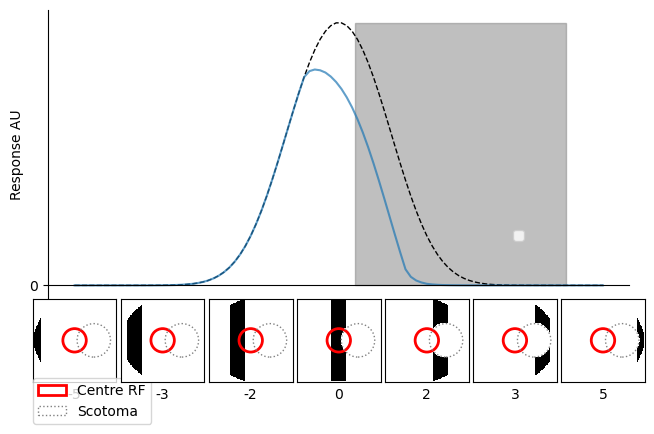

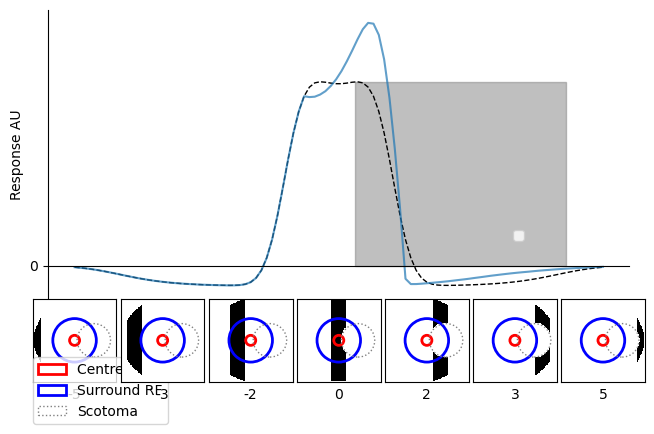

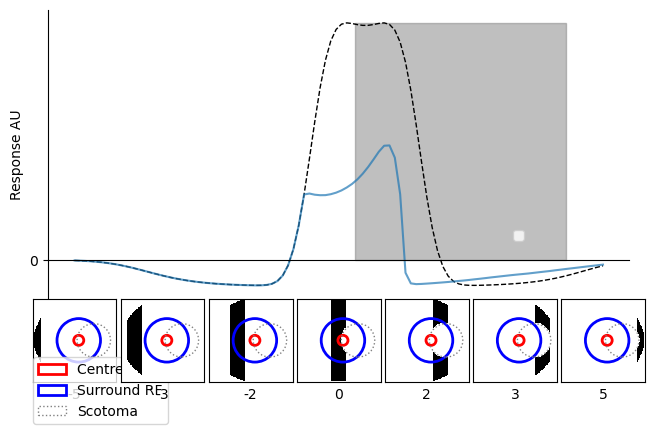

In [35]:
resp_kwargs = {
    'bar': {
        'linestyle' : '--',
        'alpha' : 1, 
        'lw' : 1, 
        'color' : 'k', 
    },
    'scot': {
        'linestyle' : '-',
        'alpha' : .7, 
        'lw' : 1.5,
        # 'color' : 'k',         
    }
}

for model_id in ['gauss-1', 'norm-1', 'norm-2']:
    model, id = model_id.split('-')    
    tmp_scot_kwargs = scot_kwargs[model].copy()
    if id=='2':
        tmp_scot_kwargs['x'] = .5
        # tmp_scot_kwargs['b_val'] += 100
        # tmp_scot_kwargs['d_val'] += 100
    fig = STATIC_basic( # Norm bar
        model=model,
        resp_kwargs=resp_kwargs,
        **tmp_scot_kwargs # scot_kwargs[model]
        )
    # fig_saver.add_img(
    #     fig, f'{model_id}-static',
    #     context_note=[f'{i}={v}' for i,v in scot_kwargs[model].items()],
    #     context_note_pos=[0,1],
    #     )
plt.show()

## moving version

### function

In [8]:
# time_t_fig_size_2D = [5,10]
# time_t_hratio_2D = [2,4,2]
# time_t_fig_size_1D = [5,5]
# time_t_hratio_1D = [2,2]



# time_t_font_size = 10
# time_t_bbox_to_anchor = (0.3,1)

# def MOVIE_basic(do_scot, time_pt, model, scot_kwargs, fig_ax=None, do_2D=True):
#     if do_scot:
#         stim_list = ['bar', 'scot']
#         stim_dm = 'scot_dm'
#     else:
#         stim_list = ['bar']
#         stim_dm = 'bar_dm'    
#     np_params = np.array([
#         [scot_kwargs.get('x', 0.0),],
#         [scot_kwargs.get('y', 0.0),],
#         [scot_kwargs.get('size_1', 0.0),],
#         [scot_kwargs.get('a_val', 0.0),],
#         [scot_kwargs.get('bold_baseline', 0.0),],
#         [scot_kwargs.get('c_val', 0.0),],
#         [scot_kwargs.get('size_2', 0.0),],
#         [scot_kwargs.get('b_val', 0.0),],
#         [scot_kwargs.get('d_val', 0.0),],
#     ]).T
    
#     stim_info = stim_get_basics(scot_kwargs)
#     # Get kwargs
#     tc_x = stim_info[f'bar_xticks']
#     ts = {}
#     for iS in ['bar', 'scot']:
#         if model=='gauss':
#             this_model = Iso2DGaussianModel(stim_info[f'{iS}_prfpy_stim'], hrf='direct')
#             n_params = 6
#         elif model=='norm':
#             this_model = Norm_Iso2DGaussianModel(stim_info[f'{iS}_prfpy_stim'], hrf='direct')
#             n_params = 9
#         ts[iS] = np.squeeze(this_model.return_prediction(*list(*np_params[:,:n_params])))            

#     # PLOTTING

    
    
#     # BEGIN THE TIME LOOP
#     if fig_ax is None:
#         if do_2D:
#             fig, ax = plt.subplots(3,1, gridspec_kw={'height_ratios': time_t_hratio_2D})
#             fig.set_size_inches(time_t_fig_size_2D)
#         else:
#             fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': time_t_hratio_1D})
#             ax = [ax[0], None, ax[1]]
#             fig.set_size_inches(time_t_fig_size_1D)
#     else:
#         fig = fig_ax['fig']
#         ax = fig_ax['ax']

#     # [2] Get the receptive fields
#     # -> to find the place to put the 1D slice...
#     rf_mid_pt = np.argmin((stim_info['y_grid'] - scot_kwargs['y'])**2, axis=0)[0]
#     a_rf = np.squeeze(gauss2D_iso_cart(
#         x=stim_info['x_grid'][..., np.newaxis],
#         y=stim_info['y_grid'][..., np.newaxis],
#         mu=(scot_kwargs['x'], scot_kwargs['y']),
#         sigma=scot_kwargs['size_1']))
    
#     ax[0].plot(
#         stim_info['x_grid'][0,:],a_rf[rf_mid_pt,:], 
#         color='b', label='Activating RF')

#     if model=='norm':
#         a_rf = np.squeeze(gauss2D_iso_cart(
#             x=stim_info['x_grid'][..., np.newaxis],
#             y=stim_info['y_grid'][..., np.newaxis],
#             mu=(scot_kwargs['x'], scot_kwargs['y']),
#             sigma=scot_kwargs['size_2']))

#         ax[0].plot(
#             stim_info['x_grid'][0,:],a_rf[rf_mid_pt,:], 
#             color='r', label='Normalising RF')   
#     ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1]*1.5)
#     ax[0].legend(loc='upper center', bbox_to_anchor=time_t_bbox_to_anchor, prop={'size': time_t_font_size})

#     #[2] Plot the stimulus at time t
#     a_rad = stim_info['aperture_rad']
#     if do_2D:
#         if time_pt is not None:
#             ax[1].imshow(stim_info[stim_dm][:,:,time_pt], extent=[-a_rad, a_rad, -a_rad, a_rad], cmap='Greys', vmin=-0.1, vmax=0.1)
#         else:
#             ax[1].set_xlim(-a_rad, a_rad)
#             ax[1].set_ylim(-a_rad, a_rad)
#         # -> ADD ACTIVATING RFs.
#         a_rf_circle = mpl.patches.Circle(
#             (scot_kwargs['x'],scot_kwargs['y']), scot_kwargs['size_1']*2, color="b", linewidth=8, fill=False, alpha=1)
#         ax[1].add_patch(a_rf_circle)
#         if model=="norm":
#             n_rf_circle = mpl.patches.Circle(
#                 (scot_kwargs['x'],scot_kwargs['y']), scot_kwargs['size_2']*2, color="r", linewidth=8, fill=False, alpha=1)
#             ax[1].add_patch(n_rf_circle)        

#     # TIME SERIES
#     for iS in ['bar', 'scot']:
#         # 'silent plot'
#         ax[2].plot(
#             tc_x, ts[iS], alpha=0,
#         )
#     # Add bar
#     if time_pt is not None:
#         rect_xy = (stim_info['bar_xticks'][time_pt]-stim_info['x_size']/2,0)
#         rect_height = ax[0].get_ylim()[-1]
#         rect_width = stim_info['x_size']
#         bar_patch = mpl.patches.Rectangle(
#             rect_xy, 
#             rect_width, rect_height, 
#             color="grey", linewidth=0, 
#             fill=True, alpha=.5,
#             linestyle='none', 
#             # label='_'            
#         )
#         ax[0].add_patch(bar_patch)    

#     for iS in stim_list:
#         ax[2].plot(
#             tc_x[:time_pt], 
#             ts[iS][:time_pt], 
#             color=mod_cols[model] if iS=='bar' else 'k', 
#             **resp_kwargs[iS]
#             )
#     if do_scot:
#         scot_patch = mpl.patches.Circle(
#             (stim_info['scot_x'],stim_info['scot_y']), 
#             stim_info['scot_r'],# *.65, 
#             color="grey", linewidth=1, 
#             fill=False, alpha=1,
#             linestyle='dotted', 
#             label='Scotoma'
#             )
#         ax[1].add_patch(scot_patch)

#         rect_xy = (stim_info['scot_x']-stim_info['scot_r'],0)
#         rect_height = ax[0].get_ylim()[-1]
#         rect_width = stim_info['scot_r']*2
#         scot_patch = mpl.patches.Rectangle(
#             rect_xy, 
#             rect_width, rect_height, 
#             color="grey", linewidth=1, 
#             fill=False, alpha=1,
#             linestyle='dotted', 
#             # label='_'            
#         )
#         ax[0].add_patch(scot_patch)


#     ax[0].axis('off')
#     ax[0].set_title('1D profile')
#     if do_2D:
#         ax[1].axis('off')
#         ax[1].set_title('2D profile')
#     ax[2].axis('off')
#     ax[2].set_title('Response')



#     return fig, ax


### ffmpeg

In [9]:
# for model in ['gauss', 'norm']:
#     for do_scot in [True, False]:
#         save_name = f'{model}_movie_scot-{do_scot}'
#         save_path = opj(fig_saver.path, save_name)
#         if not os.path.exists(save_path):
#             os.mkdir(save_path)
#         for time in range(50):
#             # model = 'norm'
#             fig,_ = MOVIE_basic( # Norm bar
#                 do_scot=do_scot, 
#                 time_pt=time,            
#                 model=model,
#                 scot_kwargs= scot_kwargs[model],
#                 )
#             # bloop
#             fig.savefig(f"{save_path}/file{time:03}.png", dpi=300) 
            
#             plt.close(fig)
                    
#         # Finish for loop -save as movie and delete pngs
#         # ~ make a copy of final image, & place it at front
#         os.system(f"cp {save_path}/file{time:03}.png {save_path}/file000.png") # place at front
#         os.system(f"cp {save_path}/file{time:03}.png {save_path}_final.png") # save copy

#         # Use ffmpeg to turn the saved photos into a movie
#         # >> download in your conda environment, and direct system to the location
#         # >> run function...
#         ffmpeg_dir = "/home/daghlian/.conda/envs/dag_mcmc/bin/ffmpeg"
#         # Select the directory with all of the images, and file name pattern
#         # >> -r 15 controls frame rate, can be faster or slower 
#         os.system(f"{ffmpeg_dir} -r 15 -i {save_path}/file%03d.png -codec mpeg4 -y {opj(fig_saver.path, save_name)}.mp4")


### widget 

In [10]:
from ipywidgets import widgets, interactive_output, VBox, HBox
from IPython.display import display, HTML
import io
import base64

scot_kwargs4widg = {**scot_kwargs['norm']}
# ***************** WIDGETS *****************
w_params = {
    'x'     :scot_kwargs4widg['x'] ,
    'y'     :scot_kwargs4widg['x'] ,
    'size_1':scot_kwargs4widg['size_1'],
    'size_2':scot_kwargs4widg['size_2'],
    'a_val' :scot_kwargs4widg['a_val'] ,
    'b_val' :scot_kwargs4widg['b_val'] ,
    'c_val' :scot_kwargs4widg['c_val'] ,
    'd_val' :scot_kwargs4widg['d_val'] ,
    }

w_bounds = {
    'x'     :[-5, 5],
    'y'     :[-5, 5],
    'size_1':[.1, 4] ,
    'size_2':[.1, 4] ,
    'a_val' : [0, 10],
    'b_val' : [0, 10],
    'c_val' : [0, 10],
    'd_val' : [0, 10],
}
w_params_keys = list(w_params.keys())

%matplotlib inline
widg_controls=[]
for key in w_params_keys:    
    sl=widgets.FloatSlider(
        description=key,
        value=w_params[key],
        orientation = "horizontal",
        continuous_update=False,
        font_family='monospace',
        min=w_bounds[key][0], 
        max=w_bounds[key][1], 
        )
    widg_controls.append(sl)

widg_Dict = {} 
for c in widg_controls:
    widg_Dict[c.description] = c  

fig,ax = MOVIE_basic(
    do_scot=do_scot, 
    time_pt=None,            
    model='norm',
    scot_kwargs= scot_kwargs4widg,
    )
fig_ax = {'fig':fig, 'ax':ax}

widg = widgets.VBox(tuple([widg_controls[i] for i in range(8)]))
output = widgets.Output()
main_box = widgets.HBox([widg, output])

def widg_output_to_dict(widg_output):
    # [1] Find number of plots 
    param_dict = {}
    for i,p in enumerate(w_params_keys):
        # Split widg_output[i] by ',' returning list (not including ',' itself)
        param_vals = float(widg_output[i])
        param_dict[p] = param_vals
    # We return both forms...
    return param_dict


def widg_update_N(**xvalor):

    xvalor=[]
    for i,p in enumerate(w_params_keys):
        xvalor.append(widg_controls[i].value)
    param_dict = widg_output_to_dict(xvalor)
    this_widg_args = {**scot_kwargs4widg}
    for p in param_dict.keys():
        this_widg_args[p] = param_dict[p]
    for ax in fig_ax['ax']:
        ax.clear()
    fig_ax['fig'], fig_ax['ax'] = MOVIE_basic(
        do_scot=True, 
        time_pt=None,            
        model='norm',
        scot_kwargs= this_widg_args,
        fig_ax=fig_ax,
        )
    fig_ax['fig'].set_dpi(400)
    fig_ax['fig'].set_size_inches(time_t_fig_size_2D)
    buffer = io.BytesIO()
    fig.savefig(buffer, format='png')
    buffer.seek(0)
    
    # Encode the image to base64
    img_str = base64.b64encode(buffer.read()).decode('utf-8')
    
    # Generate HTML to display the image
    html_fig = f'<img src="data:image/png;base64,{img_str}">'
    
    with output:
        output.clear_output(wait=True)
        display(HTML(html_fig))
    plt.close(fig_ax['fig'])

widg_outf = widgets.interactive_output(widg_update_N,widg_Dict)
display(main_box, widg_outf)

NameError: name 'MOVIE_basic' is not defined

# END

In [10]:
save_running_code(fig_saver.path)

<IPython.core.display.Javascript object>

Notebook not saving...
jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-07-23/r01_scot_inprinciple_2024-06-04.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb to html
[NbConvertApp] Writing 864677 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-07-23/r01_scot_inprinciple_2024-06-04.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-07-23/r01_scot_inprinciple_2024-06-04_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/code/PFA_clean/pfa_scripts/r0_reports/r01_scot_inprinciple_2024-06-04.ipynb to html
[NbConvertApp] Writing 755593 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/notebook_timeline/scot_inprinciple-2024-07-23/r01_scot_inprinciple_2024-06-04_NOCODE.html
